# How can different types of omics data in the NMDC database be related?

This notebook is an example of how different omics data types may be linked via commonly used annotation vocabularies and investigated together. In this notebook we explore biomolecules and KEGG pathways identified in a set of samples that have processed metagenomic, metaproteomics, and metabolomics data available in the NMDC Data Portal.

In [1]:
# Add renv project library to R environment variable libPaths()
.libPaths(c(.libPaths(), "../../renv/library/*/R-*/*"))

# Load required packages
suppressPackageStartupMessages({
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(readr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(purrr)
library(tibble)
library(jsonlite)
library(KEGGREST)
library(circlize)
library(pathview)
})

# Load NMDC API functions from this repo
if(Sys.getenv("COLAB_BACKEND_VERSION") == "") source("../../utility_functions.R")

if(Sys.getenv("COLAB_BACKEND_VERSION") != "") source("http://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/utility_functions.R")

## 1. Retrieve data from the NMDC database using API endpoints

### Choose data to retrieve

The NMDC data portal (https://data.microbiomedata.org/) allow us to filter data and samples according to many criteria. In this case, we use the Data Type filters (upset plot) to identify samples that have metagenomics, metaproteomics, and metabolomics data. This returns 33 samples from the study "Riverbed sediment microbial communities from the Columbia River, Washington, USA" (https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51).

### Retrieve and filter data for Columbia River sediment study

The study page linked above has the NMDC study identifier in the URL: `nmdc:sty-11-aygzgv51`. We will use the function `get_data_objects_for_study` (defined in `utility_functions.R`) to retrieve all records that represent data. This includes raw data files (e.g. FASTQ or mass spectra files) as well as processed data results output by the NMDC workflows.


In [2]:
# Retrieve all data objects associated with this study

# TODO: merge in R script PR so that this call can use the function I wrote for it
dobj <- jsonlite::fromJSON('https://api.microbiomedata.org/data_objects/study/nmdc%3Asty-11-aygzgv51') %>% 
  unnest(cols = c(data_objects))

In this case, we want to look at the processed data results for our three omics types of interest. Specifically, we want the files containing KEGG Orthology and Enzyme Commission annotations. 

One way of further identifying a NMDC `DataObject` record is by looking at its slot `data_object_type` (https://microbiomedata.github.io/nmdc-schema/data_object_type/), which contains a value from `FileTypeEnum` (https://microbiomedata.github.io/nmdc-schema/FileTypeEnum/). Based on the descriptions of `FileTypeEnum` permissible values we want to filter for results files with the following `data_object_type` values:

| Value | Description |
|:-----:|:-----------:|
|Annotation Enzyme Commission|Tab delimited file for EC annotation|
|Annotation KEGG Orthology|Tab delimited file for KO annotation|
|GC-MS Metabolomics Results|GC-MS-based metabolite assignment results table|
|Protein Report|Filtered protein report file|

In [3]:
dobj <- dobj %>%
  # Filter to biosamples with metagenome EC annotations, metagenome KO 
  # annotations, metaproteomics results, and metabolomics results
  group_by(biosample_id) %>%
  filter("Annotation Enzyme Commission" %in% data_object_type &
           "Annotation KEGG Orthology" %in% data_object_type & 
           "GC-MS Metabolomics Results" %in% data_object_type &
           "Protein Report" %in% data_object_type) %>%
  ungroup() %>%
  
  # Remove uninformative columns for simpler dataframe
  select(-c(alternative_identifiers, in_manifest, was_generated_by))

### Download selected results files
 
Now we can use the `url` slot from the filtered `DataObject` records to read in all of the files containing the annotations of interest.

In [4]:
results_by_biosample <- dobj %>%
  
  # Filter to desired results file types and create one URL column per type
  filter(data_object_type %in% c("Annotation Enzyme Commission", "Annotation KEGG Orthology",
                                 "GC-MS Metabolomics Results", "Protein Report")) %>%
  select(biosample_id, data_object_type, url) %>%
  pivot_wider(names_from = data_object_type, values_from = url) %>%
  
  # Read in the TSV/CSV results files
  # Add in column names from the IMG genome download README
  mutate(metag_ec_results = lapply(
    .$`Annotation Enzyme Commission`, 
    function(x) { 
      d <- read_tsv(x, col_names = FALSE, show_col_types = FALSE)
      names(d) <- c("gene_id", "img_ko_flag", "EC", "percent_identity",
                    "query_start", "query_end", "subj_start", "subj_end",
                    "evalue", "bit_score", "align_length")
      d
      })) %>%
  
  mutate(metag_ko_results = lapply(
    .$`Annotation KEGG Orthology`, 
    function(x) { 
      d <- read_tsv(x, col_names = FALSE, show_col_types = FALSE)
      names(d) <- c("gene_id", "img_ko_flag", "ko_term", "percent_identity",
                    "query_start", "query_end", "subj_start", "subj_end",
                    "evalue", "bit_score", "align_length")
      d
      })) %>%

  mutate(metap_results = lapply(.$`Protein Report`, read_tsv, col_names = TRUE, show_col_types = FALSE)) %>%
  mutate(metab_results = lapply(.$`GC-MS Metabolomics Results`, read_csv, col_names = TRUE, show_col_types = FALSE))


Each of the downloaded data files contains lots of information including the KO, EC, or KEGG Compound identifiers.

In [5]:

# View a snippet of the metagenome KEGG Orthology annotations file
head(results_by_biosample$metag_ko_results[[1]])

gene_id,img_ko_flag,ko_term,percent_identity,query_start,query_end,subj_start,subj_end,evalue,bit_score,align_length
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nmdc:wfmgan-11-z0q72297.1_000001_7_501,2999021309,KO:K09129,96.95,1,164,1,164,1.2e-113,370,164
nmdc:wfmgan-11-z0q72297.1_000001_822_2396,2999016232,KO:K08482,57.28,1,522,17,536,1.4e-211,685,522
nmdc:wfmgan-11-z0q72297.1_000001_2919_3773,2999016149,KO:K07652,45.16,15,267,512,790,1.8e-71,260,253
nmdc:wfmgan-11-z0q72297.1_000001_8181_8969,2999039711,KO:K07238,80.84,2,262,32,291,5.4e-144,466,261
nmdc:wfmgan-11-z0q72297.1_000002_2920_3669,2999021898,KO:K07090,80.97,3,249,1,247,6.7e-141,456,247
nmdc:wfmgan-11-z0q72297.1_000002_5075_5563,2999019508,KO:K04750,75.64,3,158,2,157,9.2e-84,284,156


From each results table we can extract the unique list of genes/proteins/metabolites identified in that sample.

In [6]:
# Metagenome annotations - Enzyme Commission
metag_ec_unique_df <- results_by_biosample %>%
  distinct(biosample_id, .keep_all = TRUE) %>%

  # Save a unique vector of annotations by type for each sample for searching later
  mutate(metag_ec_unique = lapply(.$metag_ec_results, 
                                  FUN = function(x) { sort(unique(x$EC)) })) %>%
  select(biosample_id, metag_ec_results, metag_ec_unique)



# Metagenome annotations - KEGG Orthology
metag_ko_unique_df <- results_by_biosample %>%
  distinct(biosample_id, .keep_all = TRUE) %>%

  # Save a unique vector of annotations by type for each sample for searching later
  mutate(metag_ko_unique = lapply(.$metag_ko_results, 
                                  FUN = function(x) { sort(unique(x$ko_term)) })) %>%
  select(biosample_id, metag_ko_results, metag_ko_unique)



# Metaproteome annotations - Enzyme Commission
metap_ec_unique_df <- results_by_biosample %>%
  distinct(biosample_id, .keep_all = TRUE) %>%

  # Save a unique vector of annotations by type for each sample for searching later
  mutate(metap_ec_unique = lapply(
    .$metap_results, 
    FUN = function(x) { sort(unique(x$EC_Number)) %>% strsplit(",") %>% unlist() })) %>%
  select(biosample_id, metap_results, metap_ec_unique)



# Metabolome annotations - KEGG Compound
metab_ko_unique_df <- results_by_biosample %>%
  distinct(biosample_id, .keep_all = TRUE) %>%

  # Save a unique vector of annotations by type for each sample for searching later
  mutate(metab_ko_unique = lapply(.$metab_results, 
                                  FUN = function(x) { sort(unique(x$`Kegg Compound ID`)) })) %>%
  select(biosample_id, metab_results, metab_ko_unique)


# rm(results_by_biosample)

## 2. Get IDs from other KEGG databases

Now we will use the KEGGREST package (available on Bioconductor) to make calls to the KEGG API. Using the annotations provided in the workflow results, we can look up the corresponding annotations in other KEGG databases to start drawing connections between biomolecule identifications.

### Gather metabolite information

First we will find all of the Enzyme Commission numbers available for each identified compound. These EC numbers represent enzymes involved in recorded reactions that produce the compound of interest.
Then we will do the same to pull all of the modules and pathways that each compound is a part of. 

KEGG modules are functional units of gene sets and KEGG pathways are manually drawn maps that represent known molecular interactions for biologically interesting processes. Later we will use the pathway IDs to see where our identified biomolecules interact.

In [7]:
# For each sample, assemble a dataframe of metabolite information

# Pre-allocate an empty list for metabolite dataframes
metabolite_annotations_list <- vector(mode = "list", length = length(metab_ko_unique_df$biosample_id))

for (biosample in 1:length(metab_ko_unique_df$biosample_id)) {

  unique_metabolites <- metab_ko_unique_df$metab_ko_unique[[biosample]]

  # Get EC ids for each metabolite
  ec_from_metabolites <- keggLink("enzyme", unique_metabolites)

  ec_from_metabolites <- data.frame(compound_id = names(ec_from_metabolites),
                                    ec_id = ec_from_metabolites) %>%
    nest(.by = compound_id, .key = "ec_id")

  # Get modules for each metabolite
  modules_from_metabolites <- keggLink("module", unique_metabolites)

  modules_from_metabolites <- data.frame(compound_id = names(modules_from_metabolites),
                                        module_id = modules_from_metabolites) %>%
    nest(.by = compound_id, .key = "module_id")


  # Get pathways for each metabolite
  pathways_from_metabolites <- keggLink("pathway", unique_metabolites)

  pathways_from_metabolites <- data.frame(compound_id = names(pathways_from_metabolites),
                                          pathway_id = pathways_from_metabolites) %>%
    nest(.by = compound_id, .key = "pathway_id")

  # Join compound, EC, module, pathway IDs into one dataframe
  metabolite_annotations <- data.frame(compound_id = paste0("cpd:", unique_metabolites)) %>%
    left_join(ec_from_metabolites, by = join_by(compound_id)) %>%
    left_join(modules_from_metabolites, by = join_by(compound_id)) %>%
    left_join(pathways_from_metabolites, by = join_by(compound_id)) %>%
    mutate(compound_trimmed = unique_metabolites) %>%
    
    # Search for the EC IDs in the unique identification lists 
    # for the other biomolecules in this sample
    mutate(In_Metag_Annotations = vapply(.$ec_id, function(x) { any(x$ec_id %in% tolower(metag_ec_unique_df$metag_ec_unique[[biosample]])) },
                            FUN.VALUE = TRUE)) %>%
    mutate(In_Prot_Annotations = vapply(.$ec_id, function(x) { any(x$ec_id %in% tolower(metap_ec_unique_df$metap_ec_unique[[biosample]])) },
                            FUN.VALUE = TRUE))

  # Save dataframe to list
  metabolite_annotations_list[[biosample]] <- metabolite_annotations

  # Wait for 1 second to avoid KEGG REST API limits
  Sys.sleep(1)
}

### Gather protein information

Next we will do the same thing for proteins in each sample - starting with the KO and EC IDs from the NMDC annotation workflow, identify the modules and pathways each protein is associated with, and what corresponding metabolites/genes were identified in this sample.

In [8]:
# For each sample, assemble a dataframe of protein information

# Pre-allocate an empty list for protein dataframes
protein_annotations_list <- vector(mode = "list", length = length(metap_ec_unique_df$biosample_id))

for (biosample in 1:length(metap_ec_unique_df$biosample_id)) {

  # Gather protein annotations from workflow output
  protein_annotations <- metap_ec_unique_df$metap_results[[biosample]] %>%
    select(KO, EC_Number) %>%
    rename(ko_id = KO, ec_id = EC_Number) %>%
    mutate(ec_id = trimws(strsplit(ec_id, ","))) %>%
    filter(if_any(everything(), ~ !is.na(.))) %>%
    distinct() %>%
    mutate(ko_trimmed = substring(ko_id, 4))
  
  unique_proteins <- protein_annotations$ko_trimmed
  
  # Get modules for each protein
  modules_from_proteins <- keggLink("module", unique_proteins)
  
  modules_from_proteins <- data.frame(ko_id = toupper(names(modules_from_proteins)),
                                      module_id = modules_from_proteins) %>%
    nest(.by = ko_id, .key = "module_id")
  
  
  # Get pathways for each protein
  pathways_from_proteins <- keggLink("pathway", unique_proteins)
  
  pathways_from_proteins <- data.frame(ko_id = toupper(names(pathways_from_proteins)),
                                       pathway_id = pathways_from_proteins) %>%
    nest(.by = ko_id, .key = "pathway_id")

  
  # Join KO, EC, module, pathway IDs into one dataframe
  protein_annotations <- protein_annotations %>%
    left_join(modules_from_proteins, by = join_by(ko_id)) %>%
    left_join(pathways_from_proteins, by = join_by(ko_id)) %>%
    
    # Search for corresponding biomolecules in other data types for this sample
    mutate(In_Metab_Annotations = vapply(.$ec_id, function(x) { any(tolower(x) %in% unique(unlist(metabolite_annotations_list[[biosample]]$ec_id))) },
                                         FUN.VALUE = TRUE)) %>%
    mutate(In_Metag_Annotations = vapply(.$ko_id, function(x) { any(x %in% unique(metag_ko_unique_df$metag_ko_unique[[biosample]])) },
                                         FUN.VALUE = TRUE))
  
  # Save dataframe to list
  protein_annotations_list[[biosample]] <- protein_annotations

  # Wait for 1 second to avoid KEGG REST API limits
  Sys.sleep(1)
}

### Gather gene information

Finally we will create the same list of dataframes for the metagenomes in each sample.

In [9]:
# For each sample, assemble a dataframe of gene information

# Pre-allocate an empty list for gene dataframes
gene_annotations_list <- vector(mode = "list", length = length(metag_ko_unique_df$biosample_id))

for (biosample in 1:length(metag_ko_unique_df$biosample_id)) {

  # Gather gene annotations from workflow output
  # Join KO and EC annotation dataframes using the NMDC workflow generated "gene_id"
  metag_annotations <- full_join(metag_ko_unique_df$metag_ko_results[[biosample]], 
                                 metag_ec_unique_df$metag_ec_results[[biosample]],
                                 by = join_by("gene_id")) %>%
    distinct(ko_term, EC) %>%
    filter(!is.na(EC)) %>%
    nest(.by = ko_term, .key = "EC") %>%
    rename(ko_id = ko_term, ec_id = EC) %>%
    
    mutate(ko_trimmed = substring(ko_id, 4)) %>%
  
    mutate(In_Metab_Annotations = vapply(.$ec_id, function(x) { any(tolower(x) %in% unique(unlist(metabolite_annotations_list[[biosample]]$ec_id))) },
                             FUN.VALUE = TRUE)) %>%
    mutate(In_Prot_Annotations = ko_id %in% protein_annotations_list[[biosample]]$ko_id)
  
  
  # Get modules for each gene
  # Break up vector of KO IDs, HTTP request URL gets too long
  modules_from_genes <- split(metag_annotations$ko_trimmed, 
                              ceiling(seq_along(metag_annotations$ko_trimmed)/50)) %>%
    lapply(FUN = function(x) { keggLink("module", x) }) %>%
    list_c()
  
  
  modules_from_genes <- data.frame(ko_id = toupper(names(modules_from_genes)),
                                   module_id = modules_from_genes) %>%
    nest(.by = ko_id, .key = "module_id")
  
  
  # Get pathways for each gene
  pathways_from_genes <- split(metag_annotations$ko_trimmed, 
                              ceiling(seq_along(metag_annotations$ko_trimmed)/50)) %>%
    lapply(FUN = function(x) { keggLink("pathway", x) }) %>%
    list_c()
  
  pathways_from_genes <- data.frame(ko_id = toupper(names(pathways_from_genes)),
                                    pathway_id = pathways_from_genes) %>%
    nest(.by = ko_id, .key = "pathway_id")
  
  
  # Add modules and pathways to gene annotations dataframe
  metag_annotations <- metag_annotations %>%
    left_join(modules_from_genes, by = join_by(ko_id)) %>%
    left_join(pathways_from_genes, by = join_by(ko_id))
  
  gene_annotations_list[[biosample]] <- metag_annotations

  # Wait for 1 second to avoid KEGG REST API limits
  Sys.sleep(1)

}

Warning message in full_join(metag_ko_unique_df$metag_ko_results[[biosample]], metag_ec_unique_df$metag_ec_results[[biosample]], :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 7 of `x` matches multiple rows in `y`.
ℹ Row 33960 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”



## 3. Visualize shared biomolecule identifications

The `circlize` package enables construction of circular diagrams with arcs between sectors showing relationships between multiple groups. We will use `circlize` to create a chord diagram showing where the annotations from the metagenomic, metaproteomic, and metabolomic results connect to each other. 

First, choose a biosample from the list to visualize. Then use its gathered annotations to calculate the sectors and arcs needed for the plot.

In [10]:
# Select an example biosample
example_gene <- gene_annotations_list[[1]]
example_prot <- protein_annotations_list[[1]]
example_metab <- metabolite_annotations_list[[1]]

# Scale sectors so that arc widths are proportional rather than absolute
# There are way more gene identifications than others so it gets hard to visualize as absolute counts
largest_sector_xlim <- max(length(example_gene$ko_id),
                           length(example_prot$ko_id),
                           length(example_metab$compound_id))

# Gene sector
gene_sector_xlim <- (length(example_gene$ko_id))

gene_sector_prot_count <- (sum(example_gene$In_Prot_Annotations)) * (largest_sector_xlim / gene_sector_xlim)
gene_sector_both_count <- (nrow(filter(example_gene, In_Metab_Annotations & In_Prot_Annotations))) * (largest_sector_xlim / gene_sector_xlim)
gene_sector_metab_count <-(sum(example_gene$In_Metab_Annotations)) * (largest_sector_xlim / gene_sector_xlim)

# Prot sector
prot_sector_xlim <- length(example_prot$ko_id)

prot_sector_metab_count <- sum(example_prot$In_Metab_Annotations) * (largest_sector_xlim / prot_sector_xlim)
prot_sector_both_count <- nrow(filter(example_prot, In_Metab_Annotations & In_Metag_Annotations)) * (largest_sector_xlim / prot_sector_xlim)
prot_sector_gene_count <-sum(example_prot$In_Metag_Annotations) * (largest_sector_xlim / prot_sector_xlim)


# Metab sector
metab_sector_xlim <- length(example_metab$compound_id)

metab_sector_gene_count <- sum(example_metab$In_Metag_Annotations) * (metab_sector_xlim / prot_sector_xlim)
metab_sector_both_count <- nrow(filter(example_metab, In_Metag_Annotations & In_Prot_Annotations)) * (metab_sector_xlim / prot_sector_xlim)
metab_sector_prot_count <-sum(example_metab$In_Prot_Annotations) * (metab_sector_xlim / prot_sector_xlim)

# Reset sector sizes to scaled value
gene_sector_xlim <- largest_sector_xlim
prot_sector_xlim <- largest_sector_xlim
metab_sector_xlim <- largest_sector_xlim

Now use the calculated sectors/arcs to generate the chord diagram.

Note: The first link end is drawn out of sector 'genes'.

Note: The second link end is drawn out of sector 'proteins'.

Note: The first link end is drawn out of sector 'proteins'.

Note: The first link end is drawn out of sector 'metabolites'.



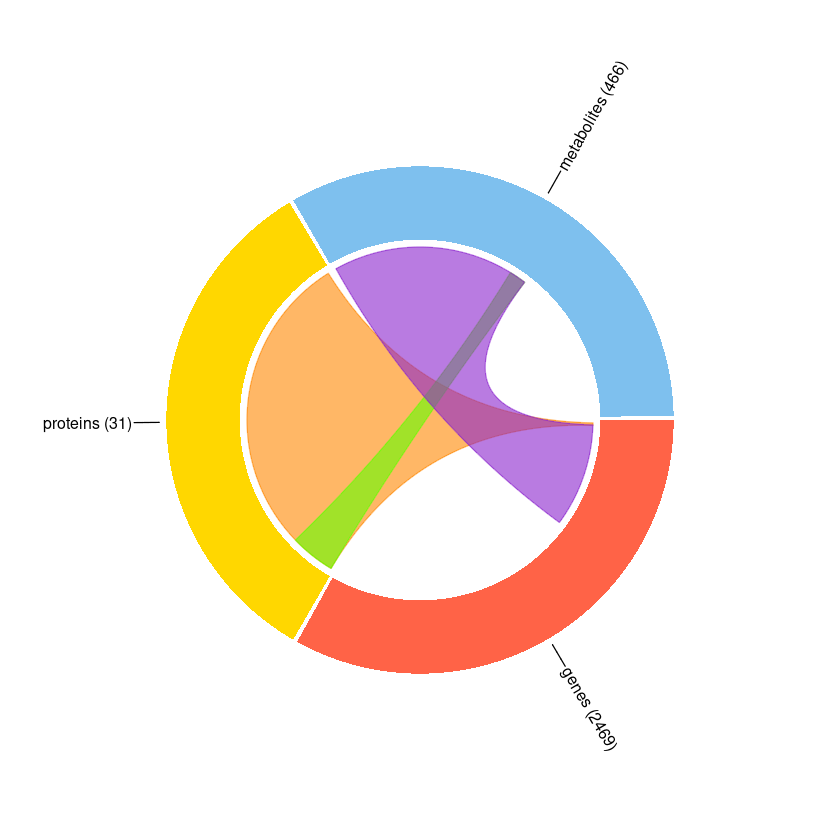

In [11]:
plot_sector_names <- c("genes", "proteins", "metabolites")
 
# Assemble data
data = data.frame(
    sectors = c(rep("genes", gene_sector_xlim),
               rep("proteins", prot_sector_xlim),
               rep("metabolites", metab_sector_xlim)),
    x = c(seq(1:gene_sector_xlim),
          seq(1:prot_sector_xlim),
          seq(1:metab_sector_xlim)),
    y = c(seq(1:gene_sector_xlim),
          seq(1:prot_sector_xlim),
          seq(1:metab_sector_xlim))) %>%
  mutate(sectors = factor(sectors, levels = plot_sector_names))
 
# Initialize the plot with the three specified sectors
circos.initialize(factors = data$sectors, x = data$x)

circos.labels(plot_sector_names, 
              x = c(gene_sector_xlim/2, prot_sector_xlim/2, metab_sector_xlim/2), 
              labels = c(paste0("genes (", nrow(example_gene), ")"),
                         paste0("proteins (", nrow(example_prot), ")"), 
                         paste0("metabolites (", nrow(example_metab), ")")),
              side = "outside")

 
# Build and color the three sectors in the outermost ring
circos.trackPlotRegion(factors = data$sectors, y=data$y, bg.col = c("tomato", "gold", "skyblue2") , bg.border = NA)
 
# Add links between sectors
circos.link("genes", c(0, gene_sector_prot_count), 
            "proteins", c(prot_sector_metab_count - prot_sector_both_count, 
                          prot_sector_metab_count - prot_sector_both_count + prot_sector_gene_count), 
            col = "#ff870099")


circos.link("proteins", c(0, prot_sector_metab_count), 
            "metabolites", c(metab_sector_gene_count - metab_sector_both_count,
                             metab_sector_gene_count - metab_sector_both_count + metab_sector_prot_count), 
            col = "#63ff0099")



circos.link("metabolites", c(0, metab_sector_gene_count), 
            "genes", c(gene_sector_prot_count - gene_sector_both_count,
                       gene_sector_prot_count - gene_sector_both_count + gene_sector_metab_count), 
            col = "#8b24cd99")

In the chord diagram, each arc is showing what proportion of identified biomolecules have a corresponding annotation in the identified biomolecules on the other end of the arc. e.g., the purple arc shows that about half of the metabolites have a related KO ID in their record that was identified in the metagenomic data for this sample. 

Areas where the ends of two arcs overlap (e.g., the green and orange arc ends at the bottom of the protein sector) indicate that those molecules have corresponding identified biomolecules in all three data types.

## 4. Calculate coverage of KEGG pathways across samples

Assemble a list of all of the pathway IDs that any biomolecules in each sample map to (obtained from API calls earlier).
The KEGG API returns duplicate IDs for each pathway, one that is blank, and one that has all of the KO elements highlighted. Exclude the highlighted maps from the list for redundancy.
Some of the maps are "overview" maps which encompass an enormous number of metabolic reactions, to the point that it is not especially informative if a compound maps to one. Exclude those pathways as well. (See https://www.genome.jp/kegg/pathway.html#global) 

In [12]:
pathways_by_biosample <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:length(pathways_by_biosample)) {

  # Get unique list of pathways from all identified biomolecules
  sample_pathways <- c(gene_annotations_list[[biosample]]$pathway_id, 
                       protein_annotations_list[[biosample]]$pathway_id,
                       metabolite_annotations_list[[biosample]]$pathway_id) %>%
    unlist(use.names = FALSE) %>%
    unique()
  
  # Look at basic pathway maps, exclude KO highlighted pathway maps
  sample_pathways <- sample_pathways[!str_detect(sample_pathways, "path:ko")]
  
  # Exclude "overview" pathway maps
  sample_pathways <- sample_pathways[!str_detect(sample_pathways, "path:map01")]
  
  pathways_by_biosample[[biosample]] <- sample_pathways
  
}

Now, using the complete list of pathways, make one more set of API calls to obtain the full list of compounds and KO elements found in that pathway. In this case we are only searching for KO and compound IDs, EC IDs in pathways just point to the corresponding KO element.

In [13]:
# Concatenate the pathways, make all the calls once, then join to pathways_by_biosample

# Get all compounds for each pathway
compounds_from_pathways <- pathways_by_biosample %>%
  unlist(use.names = FALSE) %>%
  unique() %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { keggLink("compound", x) }) %>%
  list_c()
  
# Format into a nested dataframe
compounds_from_pathways <- data.frame(pathway_id = names(compounds_from_pathways),
                                      compound_id = compounds_from_pathways) %>%
  nest(.by = pathway_id, .key = "compound_id")


# Get all KO for each pathway
ko_from_pathways <- pathways_by_biosample %>%
  unlist(use.names = FALSE) %>%
  unique() %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { keggLink("ko", x) }) %>%
  list_c()

# Format into a nested dataframe
ko_from_pathways <- data.frame(pathway_id = names(ko_from_pathways),
                               ko_id = ko_from_pathways) %>%
  nest(.by = pathway_id, .key = "ko_id")


# Count the elements that comprise each pathway for calculations later
all_pathway_elements <- full_join(compounds_from_pathways, ko_from_pathways, 
                                  by = join_by(pathway_id)) %>%
  mutate(compound_count = vapply(compound_id, 
                                 FUN = function(x) { ifelse(is.null(x), 0, nrow(x)) }, 
                                 FUN.VALUE = 1)) %>%
  mutate(ko_count =       vapply(ko_id, 
                                 FUN = function(x) { ifelse(is.null(x), 0, nrow(x)) }, 
                                 FUN.VALUE = 1)) %>%
  mutate(total_elements = compound_count + ko_count)

Now we will calculate the "coverage" of each KEGG pathway found in each biosample by simply dividing the number of biomolecules that were found in the omics data by the total number of elements in the pathway.

In [14]:
pathway_coverage_by_biosample <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:length(pathways_by_biosample)) {
  
  all_ko_detected <- unique(c(gene_annotations_list[[biosample]]$ko_id,
                              protein_annotations_list[[biosample]]$ko_id))
  
  pathway_coverage_by_biosample[[biosample]] <- all_pathway_elements %>%
    filter(pathway_id %in% pathways_by_biosample[[biosample]]) %>%
    mutate(compound_found    = vapply(.$compound_id, 
                                      function(x) { sum(x$compound_id %in% metabolite_annotations_list[[biosample]]$compound_id) }, 
                                      FUN.VALUE = 1),
           ko_found          = vapply(.$ko_id, 
                                      function(x) { sum(toupper(x$ko_id) %in% all_ko_detected) }, 
                                      FUN.VALUE = 1),
           compound_coverage = compound_found / compound_count,
           ko_coverage       = ko_found / ko_count,
           total_coverage    = (compound_found + ko_found)/total_elements) %>%
    
    select(-c(compound_id, ko_id)) %>%
    mutate_all(~ifelse(is.nan(.), NA, .)) %>%
    
    # Filter out pathways where we only found 1 element
    filter(compound_found + ko_found > 1) %>%
    arrange(-total_coverage)
}


## 5. Visualize KEGG pathway coverage across samples

Now we have a list of dataframes containing the coverage of each pathway in each biosample. We can start by visualizing this as a heatmap, where the columns are KEGG pathways, the rows are biosamples, and the color gradient shows pathways with high/low coverage in each sample.

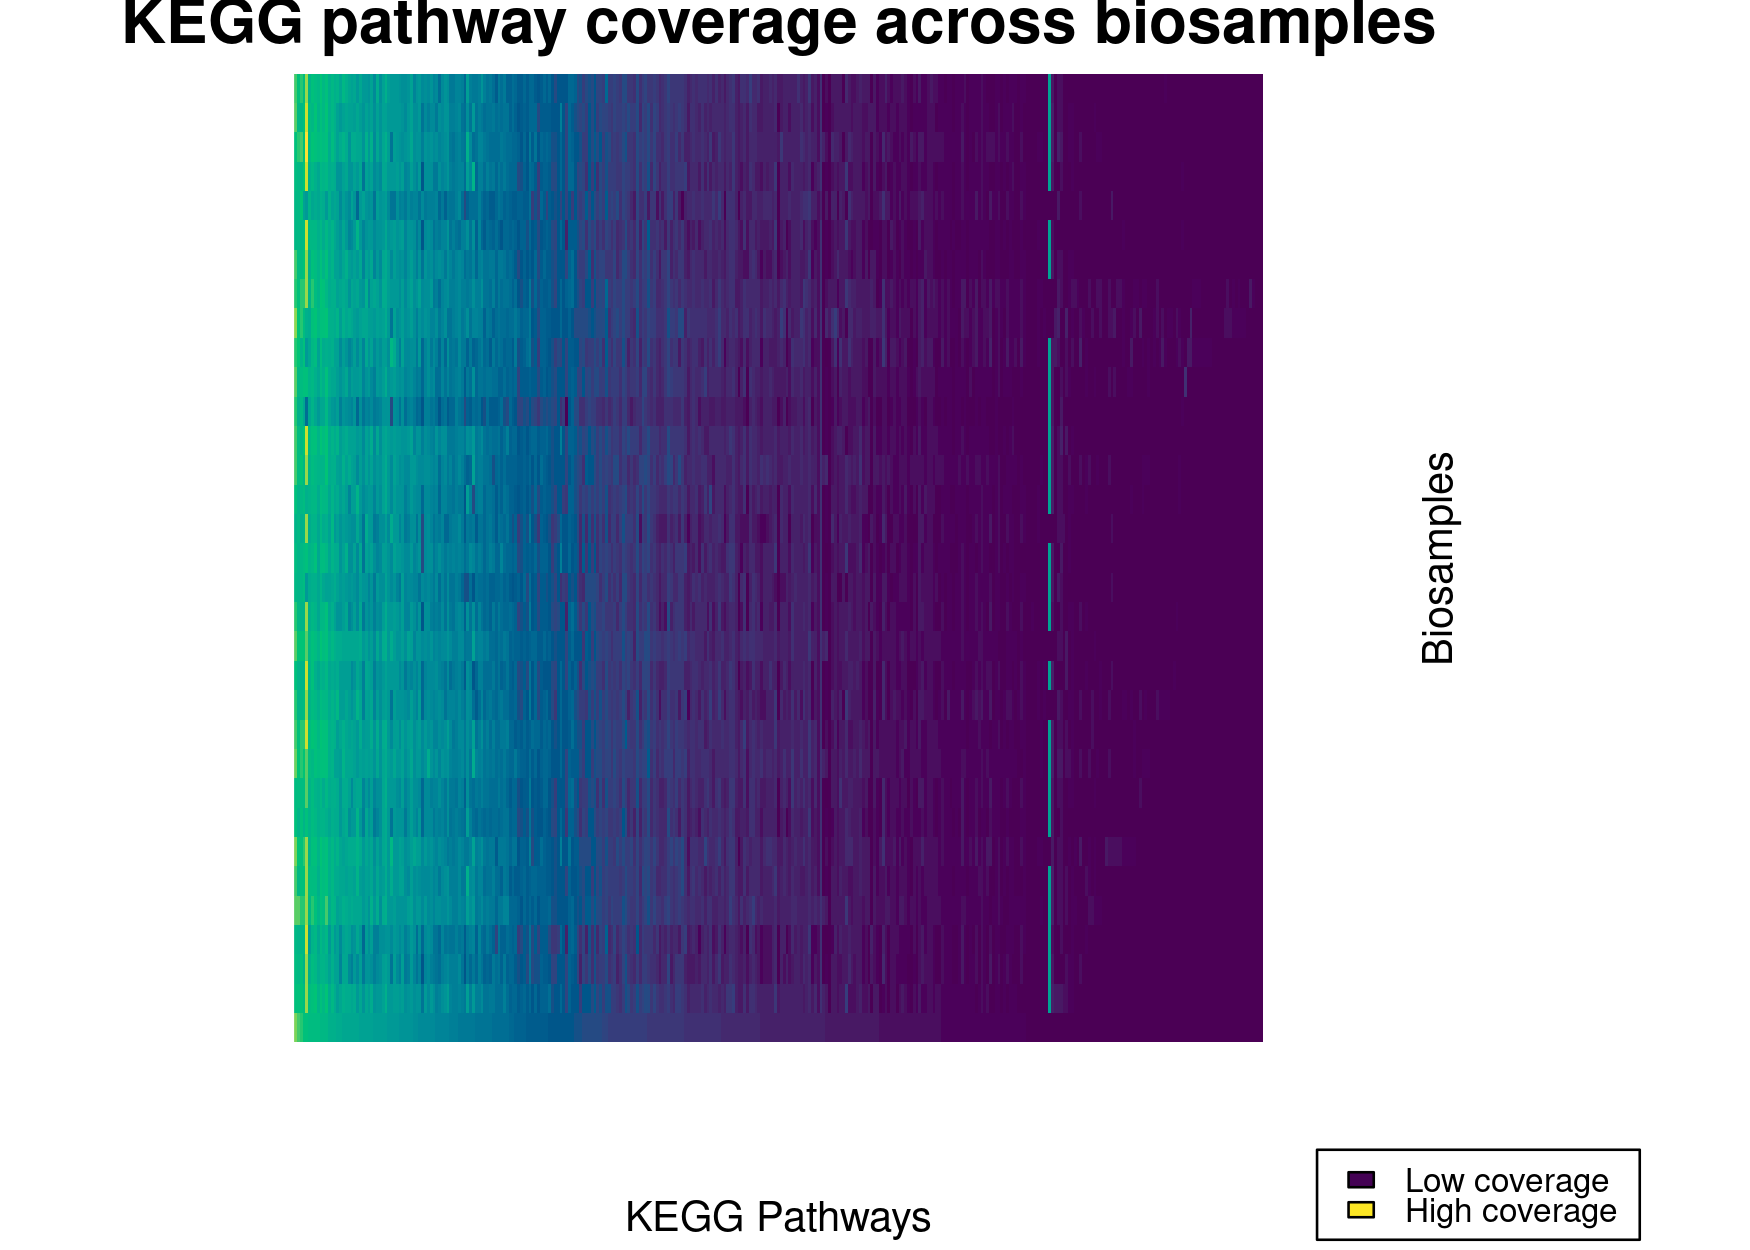

In [15]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 250)
par(xpd = TRUE)

pathway_coverage_by_biosample %>%
  bind_rows(.id = "biosample") %>%
  select(biosample, pathway_id, total_coverage) %>%
  pivot_wider(names_from = "pathway_id", values_from = "total_coverage") %>%
  replace(is.na(.), 0) %>%
  column_to_rownames(var = "biosample") %>%
  as.matrix() %>%
  
  heatmap(Rowv = NA, Colv = NA,
          labRow = FALSE, labCol = FALSE, scale = "none",
          main = "KEGG pathway coverage across biosamples",
          xlab = "KEGG Pathways",
          ylab = "Biosamples", 
          keep.dendro = FALSE, na.rm= TRUE,
          col = hcl.colors(50))

par(cex = 0.8)

legend(x = "bottomright", legend = c("Low coverage", "High coverage"), fill = c("#440154", "#FDE725"), inset = c(0, -0.2))

It does not appear that there is a huge difference in coverage between different groups of samples, samples largely share pathways where a higher proportion of KEGG orthologs and compounds were detected.

Instead, try looking at trends across all the samples, such as the pathways with the highest average coverage. The plot below displays pathways that had over 50% coverage in any sample, ordered by average coverage.

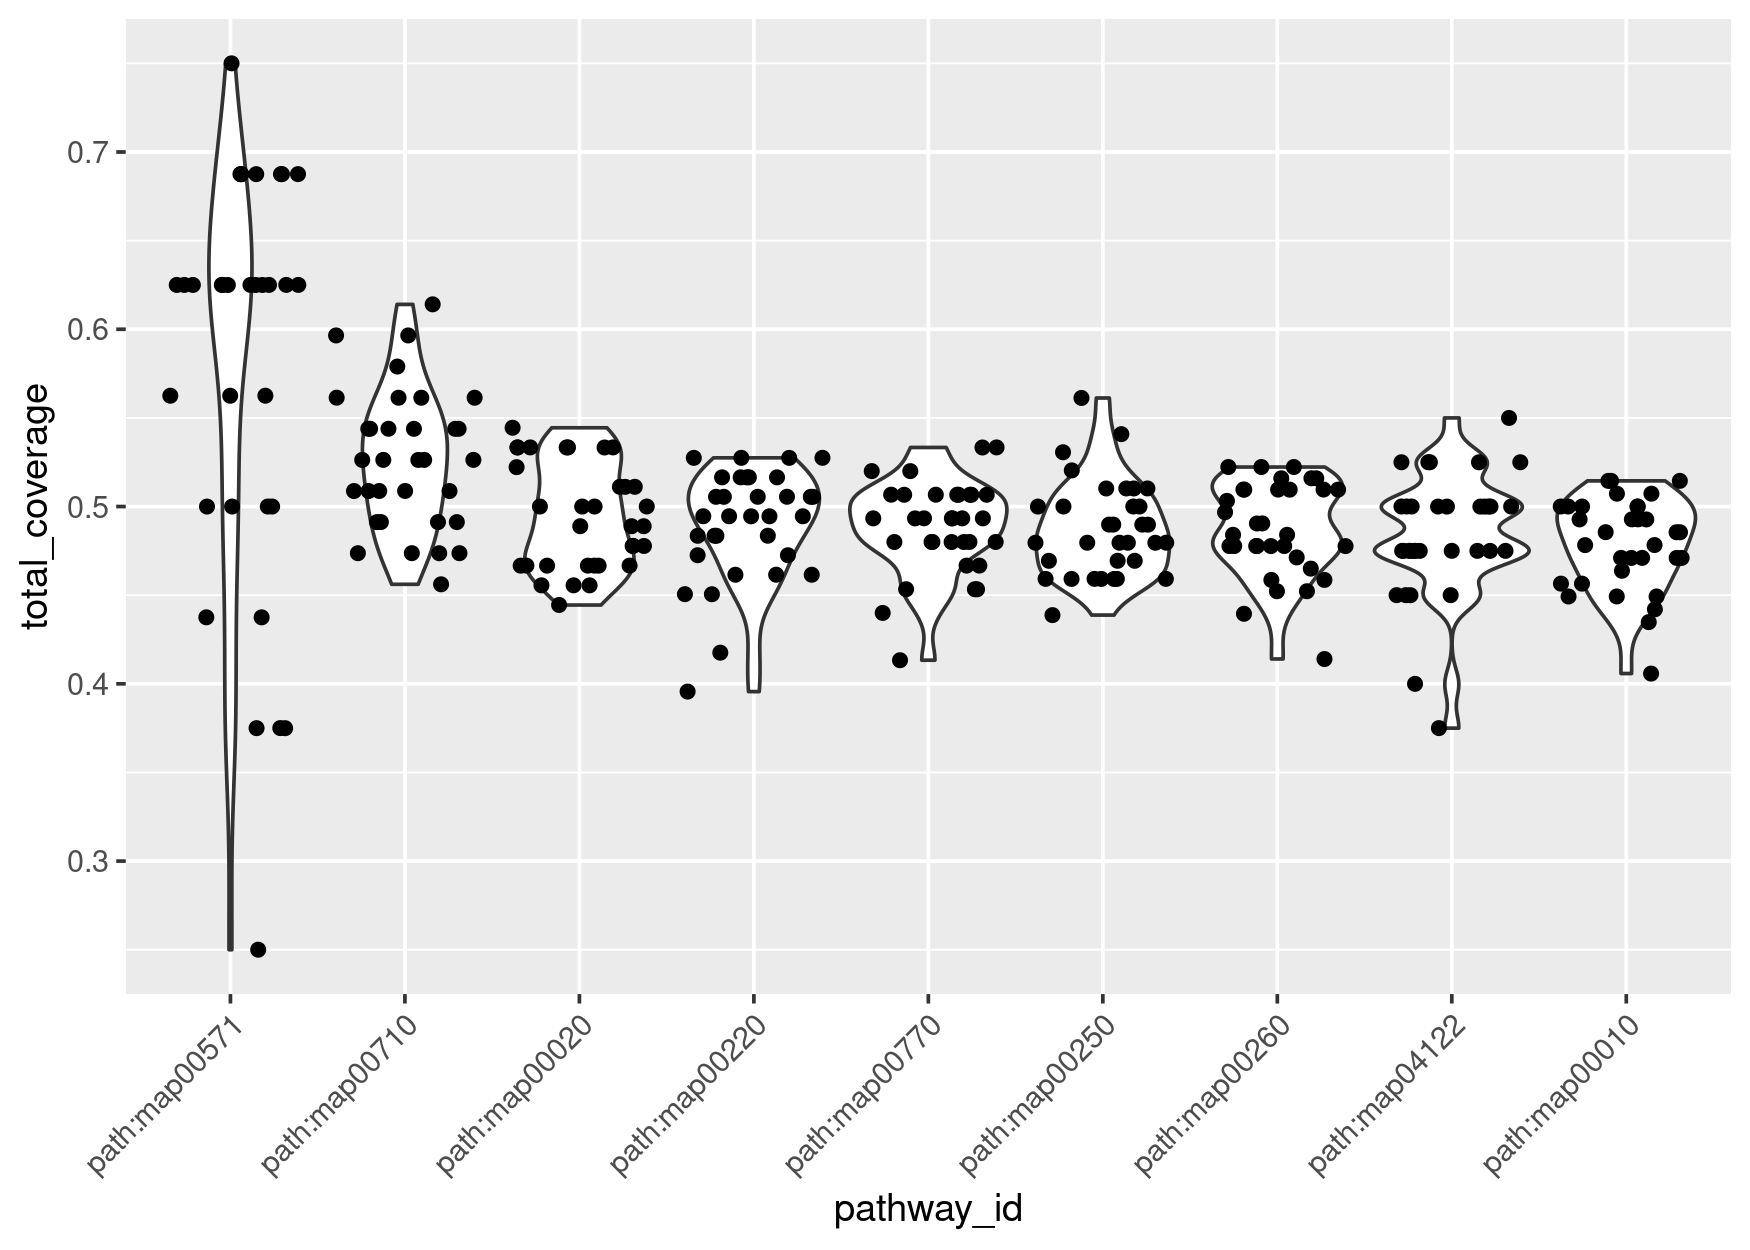

In [16]:
pathway_coverage_by_biosample %>%
  bind_rows(.id = "biosample") %>%
  select(biosample, pathway_id, total_coverage) %>%
  group_by(pathway_id) %>%
  filter(any(total_coverage > 0.5)) %>%
  mutate(average_coverage = mean(total_coverage)) %>%
  ungroup() %>%
  arrange(-average_coverage) %>%
  mutate(pathway_id = factor(pathway_id, levels = unique(pathway_id))) %>%
  
  ggplot() +
  geom_violin(aes(x = pathway_id, y = total_coverage)) +
  geom_jitter(aes(x = pathway_id, y = total_coverage)) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

We can use the KEGG pathway documentation to find some more human-readable information for each of these pathway IDs. The pathways are grouped into categories. See the table of contents at https://www.genome.jp/kegg/pathway.html.

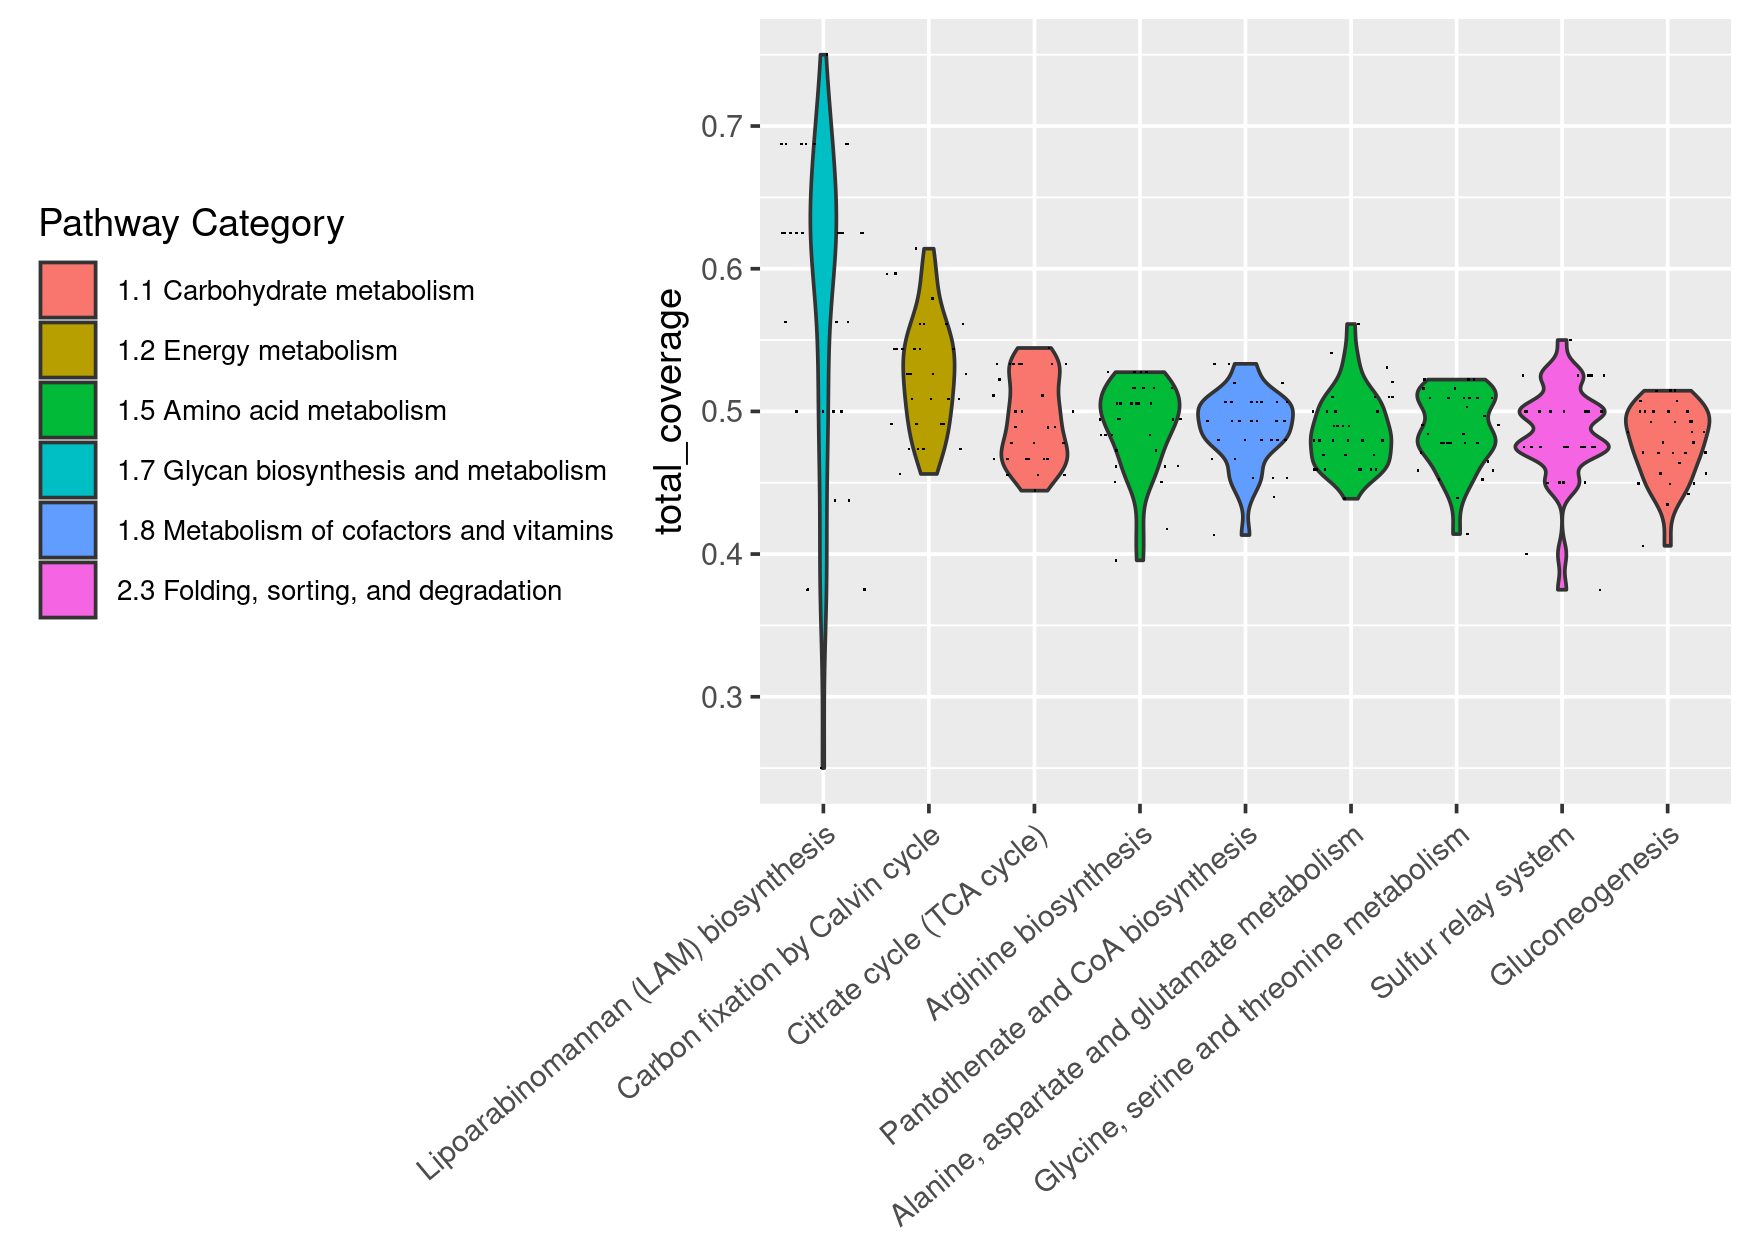

In [17]:
# Now that we see what pathways are in the plot, do it again with better labelling
top_pathways <- data.frame(
  pathway_id = c("path:map00571", "path:map00710", "path:map00020", "path:map00220", "path:map00770",
                 "path:map00250", "path:map00260", "path:map04122", "path:map00010"),
  pathway_category = c("1.7 Glycan biosynthesis and metabolism", "1.2 Energy metabolism",
                       "1.1 Carbohydrate metabolism", "1.5 Amino acid metabolism", 
                       "1.8 Metabolism of cofactors and vitamins", "1.5 Amino acid metabolism",
                       "1.5 Amino acid metabolism", "2.3 Folding, sorting, and degradation",
                       "1.1 Carbohydrate metabolism"),
  pathway_name = c("Lipoarabinomannan (LAM) biosynthesis", "Carbon fixation by Calvin cycle", 
                   "Citrate cycle (TCA cycle)", "Arginine biosynthesis", "Pantothenate and CoA biosynthesis",
                   "Alanine, aspartate and glutamate metabolism", "Glycine, serine and threonine metabolism",
                   "Sulfur relay system", "Gluconeogenesis"))


pathway_coverage_by_biosample %>%
  bind_rows(.id = "biosample") %>%
  select(biosample, pathway_id, total_coverage) %>%
  group_by(pathway_id) %>%
  filter(any(total_coverage > 0.5)) %>%
  mutate(average_coverage = mean(total_coverage)) %>%
  ungroup() %>%
  arrange(-average_coverage) %>%
  left_join(top_pathways, by = join_by(pathway_id)) %>%
  mutate(pathway_name = factor(pathway_name, levels = unique(pathway_name))) %>%
  
  ggplot() +
  geom_violin(aes(x = pathway_name, y = total_coverage, fill = pathway_category)) +
  geom_jitter(aes(x = pathway_name, y = total_coverage), shape = ".") +
  labs(fill = "Pathway Category") +
  theme(axis.text.x = element_text(angle = 40, vjust = 1, hjust=1),
        axis.title.x = element_blank(),
        legend.position = "left",
        legend.text = element_text(size = 8))

## 6. Investigate an example KEGG pathway

The second highest coverage pathway in the plot above represents the Calvin cycle, an important process for many photosynthetic organisms. More information about this pathway can be found here: https://www.genome.jp/entry/map00710

Let's calculate in how many samples each pathway element was detected.

In [18]:
# Select a pathway ID
pathway_detail_id <- "path:map00710"

# Create a vector of KO and compound IDs for the selected pathway, using the query results from earlier
pathway_detail_elements <- c(
  all_pathway_elements[which(all_pathway_elements$pathway_id == pathway_detail_id), 2],
  all_pathway_elements[which(all_pathway_elements$pathway_id == pathway_detail_id), 3]) %>% 
  unlist(use.names = FALSE)

# Pull out pathway elements for each sample
pathway_detail_identifications <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:length(pathway_detail_identifications)) {
  
  all_detections <- unique(c(gene_annotations_list[[biosample]]$ko_id,
                             protein_annotations_list[[biosample]]$ko_id,
                             metabolite_annotations_list[[biosample]]$compound_id))
  
  pathway_detail_identifications[[biosample]] <- data.frame(
    biomolecules = all_detections[toupper(all_detections) %in% toupper(pathway_detail_elements)])

}

# Count how many samples each pathway biomolecule appeared in
pathway_detail_identifications <- pathway_detail_identifications %>%
  bind_rows(.id = "biosample") %>%
  group_by(biomolecules) %>%
  summarize(sample_frequency = n()) %>% 
  ungroup() %>%
  # Calculate proportion of samples where the molecule was identified
  mutate(sample_frequency = sample_frequency/length(pathway_detail_identifications)) %>%
  # Clean up biomolecule ID format for pathview (below)
  mutate(biomolecules = str_match(biomolecules, ":(.+)$")[,2])

pathway_detail_identifications <- pull(pathway_detail_identifications) %>%
  setNames(pathway_detail_identifications$biomolecules)  


We can now use the `pathview` package to generate a colored version of the KEGG pathway diagram. The call to `pathview()` takes named vectors of genes and compounds separately and will apply the given color scale to the numeric values in the vector. This is intended for expression data but here the numeric values being represented are the proportion of samples where the biomolecule was identified across our omics data.

We can see that most of the rectangles on the map (KEGG renders them with EC numbers, but they each also correspond to a KO record) are highlighted in pink, showing that we found those genes in most of the samples. Most of the compounds identified were found in around half of the samples.

In [20]:
## TODO update this URL to main after merging
if(Sys.getenv("COLAB_BACKEND_VERSION") != "") download.file(url = "https://github.com/microbiomedata/nmdc_notebooks/blob/91-create-notebook-integrating-metag-metap-metab-data-r/omics_types_integration/R/ko00710.pathview.png")


![KEGG pathway map with genes/compounds colored by sample appearance](ko00710.pathview.png)


The code below, when uncommented, will generate the colored diagram and save it to the working directory.

In [21]:
# Save a colored KEGG pathway map to the working folder
# pathview(
#   gene.data = pathway_detail_identifications[which(str_detect(names(pathway_detail_identifications), "K"))],
#   cpd.data = pathway_detail_identifications[which(str_detect(names(pathway_detail_identifications), "C"))],
#   pathway.id = str_match(pathway_detail_id, ":map(.+)$")[,2],
#   species = "ko",
#   kegg.native = TRUE,
#   same.layer = TRUE,
#   limit = list(gene = c(0, 1), cpd = c(0, 1)),
#   bins = 14,
#   low=list(gene="cadetblue"),
#   mid = list(gene = "goldenrod"),
#   high=list(gene="palevioletred"),
#   key.align = "y"
# )

## Licensing Information

This notebook uses the KEGGREST and pathview R packages to interface with the KEGG API. Use of the KEGG API is restricted to academic users. Non-academic users must obtain a commercial license. (See https://www.kegg.jp/kegg/legal.html) The National Microbiome Data Collaborative use of KEGG is covered by license (license information).

//### get license info

## Package Citations

Gu Z, Gu L, Eils R, Schlesner M, Brors B (2014). “circlize implements and enhances circular visualization in R.” Bioinformatics, 30, 2811-2812.

Luo, Weijun, Brouwer, Cory (2013). “Pathview: an R/Bioconductor package for pathway-based data integration and visualization.” Bioinformatics, 29(14), 1830-1831. doi:10.1093/bioinformatics/btt285.

Tenenbaum D, Maintainer B (2024). KEGGREST: Client-side REST access to the Kyoto Encyclopedia of Genes and Genomes (KEGG). R package version 1.46.0, https://bioconductor.org/packages/KEGGREST.
